# Importing Libraries

In [26]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import spacy
from nltk.corpus import stopwords
import re
import string
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

In [162]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\srini\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\srini\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\srini\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\srini\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Creating Job pattern

Read Job data from the modified dataset which is feature engineered to pick skills from job description for non-skill entries in skills column.

In [166]:
jobs_trainset_df = pd.read_csv('jobs_modified.csv')
jobs_trainset_df.head()

,Unnamed: 0,advertiserurl,company,employmenttype_jobstatus,jobdescription,jobid,joblocation_address,jobtitle,postdate,shift,site_name,skills,uniq_id
0,0,https://www.dice.com/jobs/detail/Information-S...,University of Chicago/IT Services,Full Time,The University of Chicago has a rapidly growin...,Dice Id : 10114469,"Chicago, IL",Information Security Engineer,1 week ago,Telecommuting not available|Travel not required,NaN,"linux/unix, network monitoring, incident respo...",8aec88cba08d53da65ab99cf20f6f9d9
1,1,https://www.dice.com/jobs/detail/Business-Solu...,"Galaxy Systems, Inc.",Full Time,"GalaxE.SolutionsEvery day, our solutions affec...",Dice Id : CXGALXYS,"Schaumburg, IL",Business Solutions Architect,2 weeks ago,Telecommuting not available|Travel not required,NaN,"Enterprise Solutions Architecture, business in...",46baa1f69ac07779274bcd90b85d9a72
2,2,https://www.dice.com/jobs/detail/DevOps-Engine...,Matrix Resources,Full Time,Midtown based high tech firm has an immediate ...,Dice Id : matrixga,"Atlanta, GA",DevOps Engineer,48 minutes ago,Telecommuting not available|Travel not required,NaN,"Configuration Management, Developer, Linux, Ma...",45efa1f6bc65acc32bbbb953a1ed13b7
3,3,https://www.dice.com/jobs/detail/SAP-FICO-Arch...,Yash Technologies,"Full Time, Permanant",We are looking for a Senior SAP FICO Architect...,Dice Id : 10111847,"Chicago, IL",SAP FICO Architect,2 weeks ago,Telecommuting not available|Travel required to...,NaN,"FICO, AR, AP, Asset Management, HAHA",e0ac9d926dda5e95162ef05adea7318c
4,4,https://www.dice.com/jobs/detail/Network-Engin...,Noble1,"Full Time, Direct Hire",Network Engineer Job Description A Network Eng...,Dice Id : 90884761,"Atlanta, GA",Network Engineer,1 hour ago,Telecommuting not available|Travel not required,NaN,"Cisco, DNS, HTTP, Networking, Network Engineer...",e7e326053c586bd94e59f1fd74de4a1b


In [167]:
jobs_trainset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22000 entries, 0 to 21999
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                22000 non-null  int64 
 1   advertiserurl             22000 non-null  object
 2   company                   21950 non-null  object
 3   employmenttype_jobstatus  21770 non-null  object
 4   jobdescription            22000 non-null  object
 5   jobid                     22000 non-null  object
 6   joblocation_address       21997 non-null  object
 7   jobtitle                  22000 non-null  object
 8   postdate                  22000 non-null  object
 9   shift                     21643 non-null  object
 10  site_name                 3490 non-null   object
 11  skills                    21957 non-null  object
 12  uniq_id                   22000 non-null  object
dtypes: int64(1), object(12)
memory usage: 2.2+ MB


- Considering jobid, jobtitle, and skills for further preprocessing.

In [174]:
job_columns = ['jobid']+['jobtitle']+['skills']
jobs_trainset_df = jobs_trainset_df[job_columns]
jobs_trainset_df.head()

,jobid,jobtitle,skills
0,Dice Id : 10114469,Information Security Engineer,linux unix network monitor incident response s...
1,Dice Id : CXGALXYS,Business Solutions Architect,enterprise solutions architecture business int...
2,Dice Id : matrixga,DevOps Engineer,configuration management developer linux manag...
3,Dice Id : 10111847,SAP FICO Architect,fico asset management haha
4,Dice Id : 90884761,Network Engineer,cisco dns http network network engineer securi...


This step involves
- Noise reduction by removing punctuations, tags, stopwords
- Normalization by lemmatizing words based on their roots 

In [170]:
stops = set(stopwords.words('english'))
wn = WordNetLemmatizer()

def remove_stops(word):
    return  word not in stops and word not in list(string.punctuation)  and len(word)>2   
  
def preprocessing(corpus):
  temp_txt = []
  processed_text = []
  corpus = re.sub("'", "",corpus)
  corpus=re.sub("(\\d|\\W)+"," ",corpus) 
  corpus = corpus.replace("nbsp", "")
  temp_txt = [ wn.lemmatize(word, pos="v") for word in word_tokenize(corpus.lower()) if remove_stops(word)]
  processed_text = [word for word in temp_txt if remove_stops(word)]
  return " ".join(processed_text)

In [171]:
jobs_trainset_df['skills'] = jobs_trainset_df['skills'].map(str).apply(clean_txt)
jobs_trainset_df['skills'] = jobs_trainset_df['skills'].str.lower()
jobs_trainset_df.head()

,jobid,jobtitle,skills
0,Dice Id : 10114469,Information Security Engineer,linux unix network monitor incident response s...
1,Dice Id : CXGALXYS,Business Solutions Architect,enterprise solutions architecture business int...
2,Dice Id : matrixga,DevOps Engineer,configuration management developer linux manag...
3,Dice Id : 10111847,SAP FICO Architect,fico asset management haha
4,Dice Id : 90884761,Network Engineer,cisco dns http network network engineer securi...


# Creating User pattern

In [172]:
user_trainset_df = pd.read_csv("survey_results_public.csv")
user_trainset_df.info(verbose=True)

c:\python39\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (8,12,13,14,15,16,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98855 entries, 0 to 98854
Data columns (total 129 columns):
 #    Column                       Dtype  
---   ------                       -----  
 0    Respondent                   int64  
 1    Hobby                        object 
 2    OpenSource                   object 
 3    Country                      object 
 4    Student                      object 
 5    Employment                   object 
 6    FormalEducation              object 
 7    UndergradMajor               object 
 8    CompanySize                  object 
 9    DevType                      object 
 10   YearsCoding                  object 
 11   YearsCodingProf              object 
 12   JobSatisfaction              object 
 13   CareerSatisfaction           object 
 14   HopeFiveYears                object 
 15   JobSearchStatus              object 
 16   LastNewJob                   object 
 17   AssessJob1                   float64
 18   AssessJob2              

- This sections picks data from attributes like Respondent,LanguageWorkedWith,DatabaseWorkedWith,PlatformWorkedWith,FrameworkWorkedWith,IDE,Methodology,VersionControl
- Combine these attributes to form Job pattern with skills

In [173]:
user_trainset_df = user_trainset_df[['Respondent','LanguageWorkedWith','DatabaseWorkedWith','PlatformWorkedWith','FrameworkWorkedWith','IDE','Methodology','VersionControl']]
user_trainset_df['Job_Pattern'] = user_trainset_df[user_trainset_df.columns[1:]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)
user_trainset_df = user_trainset_df[['Respondent','Job_Pattern']]
user_trainset_df.head()

,Respondent,Job_Pattern
0,1,"JavaScript;Python;HTML;CSS,Redis;SQL Server;My..."
1,3,"JavaScript;Python;Bash/Shell,Redis;PostgreSQL;..."
2,4,
3,5,C#;JavaScript;SQL;TypeScript;HTML;CSS;Bash/She...
4,7,"C;C++;Java;Matlab;R;SQL;Bash/Shell,SQL Server;..."


This section clean the Job_Pattern attribute by noise removal and normalization steps

In [126]:
user_trainset_df['Job_Pattern'] = user_trainset_df['Job_Pattern'].map(str).apply(clean_txt)
user_trainset_df['Job_Pattern'] = user_trainset_df['Job_Pattern'].str.lower()
user_trainset_df.head()

,Respondent,Job_Pattern
0,1,javascript python html css redis sql server my...
1,3,javascript python bash shell redis postgresql ...
2,4,
3,5,javascript sql typescript html css bash shell ...
4,7,java matlab sql bash shell sql server postgres...


In [127]:
user_trainset_df.isnull().sum()

Respondent     0
Job_Pattern    0
dtype: int64

In [128]:
u = 302
index = np.where(user_trainset_df['Respondent'] == u)[0][0]
user_q = user_trainset_df.iloc[[index]]
user_q.Job_Pattern

199    javascript php python sql bash shell mongodb r...
Name: Job_Pattern, dtype: object

## Using TF-IDF

In [164]:
#initializing tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_jobid = tfidf_vectorizer.fit_transform((jobs_trainset_df['skills'])) #fitting and transforming the vector
tfidf_jobid

<22000x8743 sparse matrix of type '<class 'numpy.float64'>'
	with 171056 stored elements in Compressed Sparse Row format>

In [129]:
user_tfidf = tfidf_vectorizer.transform(user_q['Job_Pattern'])
cos_similarity_tfidf = map(lambda x: cosine_similarity(user_tfidf, x),tfidf_jobid)

In [130]:
output2 = list(cos_similarity_tfidf)

In [131]:
output2

[array([[0.02076725]]),
 array([[0.]]),
 array([[0.0312141]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.04354678]]),
 array([[0.03467821]]),
 array([[0.]]),
 array([[0.02711148]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.02281691]]),
 array([[0.02658874]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.22538546]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.06981742]]),
 array([[0.01900824]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.05324921]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.02725315]]),
 array([[0.00620106]]),
 array([[0.01358619]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.0170535]]),
 array([[0.22538546]]),
 array([[0.]]),
 array([[0.04269482]]),
 array([[0.0496897]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.18824426]]),
 ar

In [132]:
corpus = []
def get_recommendation(top, jobs_trainset_df, scores):
  global corpus
  recommendation = pd.DataFrame(columns = ['ApplicantID', 'jobid',  'jobtitle', 'score'])
  count = 0
  for i in top:
      recommendation.at[count, 'ApplicantID'] = u
      print(jobs_trainset_df['skills'][i])
#       text = " ".join(jobs_trainset_df['skills'][i])
      corpus.append(jobs_trainset_df['skills'][i])
      recommendation.at[count, 'jobid'] = jobs_trainset_df['jobid'][i]
      recommendation.at[count, 'jobtitle'] = jobs_trainset_df['jobtitle'][i]
      recommendation.at[count, 'score'] =  scores[count]
      count += 1
  return recommendation

In [133]:
top = sorted(range(len(output2)), key=lambda i: output2[i], reverse=True)[:10]
list_scores = [output2[i][0][0] for i in top]
get_recommendation(top,jobs_trainset_df, list_scores)

aws mongodb sql mysql oracle git memcached redis
sql sql sql postgresql etl mongodb redis scrum cloud aws sql sql sql postgresql etl mongodb redis scrum cloud aws
php aws elasticsearch
php mvc python node javascript aws agile
ror agile tdd git jira jenkins rspec angularjs mysql mongodb elasticsearch redis hadoop aws azure google vmware
big data hadoop hive spark sql agile scrum kanban lean
python ruby javascript django node html css aws mysql postgresql
python django mysql postgresql solr elasticsearch
kanban scrum
windows vim


,ApplicantID,jobid,jobtitle,score
0,302,Dice Id : 10310436,NoSQL Database Developer,0.464222
1,302,Dice Id : cybercod,Database Engineer/Architect,0.349474
2,302,Dice Id : 10286986,"PHP, AWS, ElasticSearch Engineer for Profitabl...",0.302512
3,302,Dice Id : 10528858,PHP-MVC-Developer,0.291145
4,302,Dice Id : 10212364,RUBY ON RAILS ENGINEER,0.277024
5,302,Dice Id : usts,Hadoop Developer,0.274629
6,302,Dice Id : 10439011,Software Engineer (Python),0.272384
7,302,Dice Id : 10314123,Open Source Developer,0.2718
8,302,Dice Id : RTL301590,Technical Project Manager,0.267528
9,302,Dice Id : 10111360,Windows Administrator,0.267118


## Using CountVectorizer

In [134]:
count_vectorizer = CountVectorizer()

In [135]:
count_jobid = count_vectorizer.fit_transform((jobs_trainset_df['skills'])) #fitting and transforming the vector
count_jobid

<22000x8743 sparse matrix of type '<class 'numpy.int64'>'
	with 171056 stored elements in Compressed Sparse Row format>

In [136]:
user_count = count_vectorizer.transform(user_q['Job_Pattern'])
cos_similarity_countv = map(lambda x: cosine_similarity(user_count, x),count_jobid)

In [137]:
output_count = list(cos_similarity_countv)

In [138]:
output_count

[array([[0.05976143]]),
 array([[0.]]),
 array([[0.05976143]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.06299408]]),
 array([[0.08451543]]),
 array([[0.]]),
 array([[0.07142857]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.05455447]]),
 array([[0.04454354]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.28347335]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.13363062]]),
 array([[0.04583492]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.13363062]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.09449112]]),
 array([[0.01698824]]),
 array([[0.0433555]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.048795]]),
 array([[0.28347335]]),
 array([[0.]]),
 array([[0.09449112]]),
 array([[0.11952286]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.26726124]]),
 ar

In [139]:
top = sorted(range(len(output_count)), key=lambda i: output_count[i], reverse=True)[:10]
list_scores = [output_count[i][0][0] for i in top]
get_recommendation(top, jobs_trainset_df, list_scores)

aws mongodb sql mysql oracle git memcached redis
php mvc python node javascript aws agile
php python css sass javascript git grunt aws sql agile
sql sql sql postgresql etl mongodb redis scrum cloud aws sql sql sql postgresql etl mongodb redis scrum cloud aws
html css javascript jquery angularjs node restful api aws linux bash git sql
python ruby javascript django node html css aws mysql postgresql
linux mysql sql php dns git sdlc
php wordpress javascript jquery git githumb mobile node react angular mysql
javascript design linux git react javascript design linux git react
java linux python mysql git


,ApplicantID,jobid,jobtitle,score
0,302,Dice Id : 10310436,NoSQL Database Developer,0.467707
1,302,Dice Id : 10528858,PHP-MVC-Developer,0.428571
2,302,Dice Id : norny001,Sr. PHP Developer,0.41833
3,302,Dice Id : cybercod,Database Engineer/Architect,0.377964
4,302,Dice Id : RTL301590,Softeware Development Engineer,0.3669
5,302,Dice Id : 10439011,Software Engineer (Python),0.358569
6,302,Dice Id : 90907072,Linux Database Administrator-Full Time (Remote...,0.357143
7,302,Dice Id : 10364869,PHP/WORDPRESS ENGINEER,0.341882
8,302,Dice Id : cybercod,Senior JavaScript Developer,0.338062
9,302,Dice Id : 90963011,Software Engineer - JAVA,0.338062


## Using Spacy

In [23]:
!python -m spacy download en_core_web_lg

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


distutils: C:\Python39\Include\UNKNOWN
sysconfig: C:\Python39\Include
user = False
home = None
root = None
prefix = None
distutils: C:\Python39\Include\UNKNOWN
sysconfig: C:\Python39\Include
user = False
home = None
root = None
prefix = None
You should consider upgrading via the 'C:\Python39\python.exe -m pip install --upgrade pip' command.


In [24]:
!dir  C:\Python39\Lib\site-packages\en_core_web_lg\en_core_web_lg-3.0.0

 Volume in drive C is Windows
 Volume Serial Number is 0C5E-652E

 Directory of C:\Python39\Lib\site-packages\en_core_web_lg\en_core_web_lg-3.0.0

04/25/2021  02:22 PM    <DIR>          .
04/25/2021  02:22 PM    <DIR>          ..
04/25/2021  02:22 PM             6,259 accuracy.json
04/25/2021  02:22 PM    <DIR>          attribute_ruler
04/25/2021  02:22 PM             5,269 config.cfg
04/25/2021  02:22 PM    <DIR>          lemmatizer
04/25/2021  02:22 PM             9,388 meta.json
04/25/2021  02:22 PM    <DIR>          ner
04/25/2021  02:22 PM    <DIR>          parser
04/25/2021  02:22 PM    <DIR>          senter
04/25/2021  02:22 PM    <DIR>          tagger
04/25/2021  02:22 PM    <DIR>          tok2vec
04/25/2021  02:22 PM            77,375 tokenizer
04/25/2021  02:22 PM    <DIR>          vocab
               4 File(s)         98,291 bytes
              10 Dir(s)  362,483,933,184 bytes free


In [143]:
nlp = spacy.load('C:\Python39\Lib\site-packages\en_core_web_lg\en_core_web_lg-3.0.0')

In [144]:
%%time
list_docs = []
for i in range(len(jobs_trainset_df)):
  doc = nlp("u'" + jobs_trainset_df['skills'][i] + "'")
  list_docs.append((doc,i))
print(len(list_docs))

22000
Wall time: 2min 46s


In [145]:
def calculateSimWithSpaCy(nlp, df, user_text, n=6):
    # Calculate similarity using spaCy
    list_sim =[]
    doc1 = nlp("u'" + user_text + "'")
    for i in df.index:
      try:
            doc2 = list_docs[i][0]
            score = doc1.similarity(doc2)
            list_sim.append((doc1, doc2, list_docs[i][1],score))
      except:
        continue

    return  list_sim

In [146]:
user_q.Job_Pattern[199]

'javascript php python sql bash shell mongodb redis mysql postgresql memcached elasticsearch aws linux mac serverless node react atom phpstorm vim visual studio code agile kanban lean scrum git'

In [147]:
%%time
 df3 = calculateSimWithSpaCy(nlp, jobs_trainset_df, user_q.Job_Pattern[199], n=15)
df3

Wall time: 2.39 s


[(u'javascript php python sql bash shell mongodb redis mysql postgresql memcached elasticsearch aws linux mac serverless node react atom phpstorm vim visual studio code agile kanban lean scrum git',
  u'linux unix network monitor incident response systems administration security accessment',
  0,
  0.47037647755269096),
 (u'javascript php python sql bash shell mongodb redis mysql postgresql memcached elasticsearch aws linux mac serverless node react atom phpstorm vim visual studio code agile kanban lean scrum git',
  u'enterprise solutions architecture business inteligence report report',
  1,
  0.33034376087502887),
 (u'javascript php python sql bash shell mongodb redis mysql postgresql memcached elasticsearch aws linux mac serverless node react atom phpstorm vim visual studio code agile kanban lean scrum git',
  u'configuration management developer linux management process engineer vmware',
  2,
  0.6022882238962961),
 (u'javascript php python sql bash shell mongodb redis mysql postg

In [148]:
df_recom_spacy = pd.DataFrame(df3).sort_values([3], ascending=False).head(11)

In [149]:
df_recom_spacy.reset_index(inplace=True)

In [150]:
index_spacy = df_recom_spacy[2]
list_scores = df_recom_spacy[3]

In [151]:
get_recommendation(index_spacy, jobs_trainset_df, list_scores)

years professional enterprise postgres couchbase nosql servers javascript bash shell python perl ruby java clojure
infrastructure automation bash python ruby linux unix devops nosql databases mongodb redis memcache
api developer embed git linux mongodb nosql oop software engineer sql sql server svn
devops linux windows sql server mysql apache tomcat nginx php couchbase rabbitmq akamai bash powershell python aws
java nodejs ruby scala python powershell bash azure aws rackspace openstack soe rest html javascript css angularjs react mongodb sql server mysql postgres cassandra oracle
html css javascript jquery bootstrap rest json angular mvc soa oop php cakephp laravel uml data architecture class design scrum sdlc linux subversion github mysql innodb cluster replication high availability aws apache https haproxy nginx unit test
java python linux mongodb mysql agilescrum
drupal sharepoint sql client face node html css javascript oracle mysql cassandra mongodb git subversion ios android sub 

,ApplicantID,jobid,jobtitle,score
0,302,Dice Id : primusga,Senior Software Engineer,0.912077
1,302,Dice Id : PERFRES,DevOps Architect,0.908732
2,302,Dice Id : rhalfint,Software Engineer,0.907532
3,302,Dice Id : 10439011,Sr. DevOps Engineer,0.904083
4,302,Dice Id : 10122941,Full Stack Java Engineer,0.902031
5,302,Dice Id : RTX1ba123,Senior Software Engineer,0.902003
6,302,Dice Id : 10198890,"Java, Python, C, MongoDB Developer",0.901385
7,302,Dice Id : RTL90949,Drupal Web Team Lead,0.898463
8,302,Dice Id : 10352633,Sr Software Engineer - Full Stack or Back End,0.898256
9,302,Dice Id : rhalfint,Backend Web API/PHP Engineer,0.897495


In [152]:
corpus

['aws mongodb sql mysql oracle git memcached redis',
 'sql sql sql postgresql etl mongodb redis scrum cloud aws sql sql sql postgresql etl mongodb redis scrum cloud aws',
 'php aws elasticsearch',
 'php mvc python node javascript aws agile',
 'ror agile tdd git jira jenkins rspec angularjs mysql mongodb elasticsearch redis hadoop aws azure google vmware',
 'big data hadoop hive spark sql agile scrum kanban lean',
 'python ruby javascript django node html css aws mysql postgresql',
 'python django mysql postgresql solr elasticsearch',
 'kanban scrum',
 'windows vim',
 'aws mongodb sql mysql oracle git memcached redis',
 'php mvc python node javascript aws agile',
 'php python css sass javascript git grunt aws sql agile',
 'sql sql sql postgresql etl mongodb redis scrum cloud aws sql sql sql postgresql etl mongodb redis scrum cloud aws',
 'html css javascript jquery angularjs node restful api aws linux bash git sql',
 'python ruby javascript django node html css aws mysql postgresql',
 '

## Evaluation
- This step is used to visualize the percentage of skills in jobs recommended by  all three algorithms matched with the user skills

In [154]:
#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]

### TF-IDF

In [155]:
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus[:11], n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]

[Text(0, 0, 'sql'),
 Text(1, 0, 'aws'),
 Text(2, 0, 'mongodb'),
 Text(3, 0, 'mysql'),
 Text(4, 0, 'redis'),
 Text(5, 0, 'postgresql'),
 Text(6, 0, 'scrum'),
 Text(7, 0, 'git'),
 Text(8, 0, 'elasticsearch'),
 Text(9, 0, 'python'),
 Text(10, 0, 'agile'),
 Text(11, 0, 'oracle'),
 Text(12, 0, 'memcached'),
 Text(13, 0, 'etl'),
 Text(14, 0, 'cloud'),
 Text(15, 0, 'php'),
 Text(16, 0, 'node'),
 Text(17, 0, 'javascript'),
 Text(18, 0, 'hadoop'),
 Text(19, 0, 'kanban')]

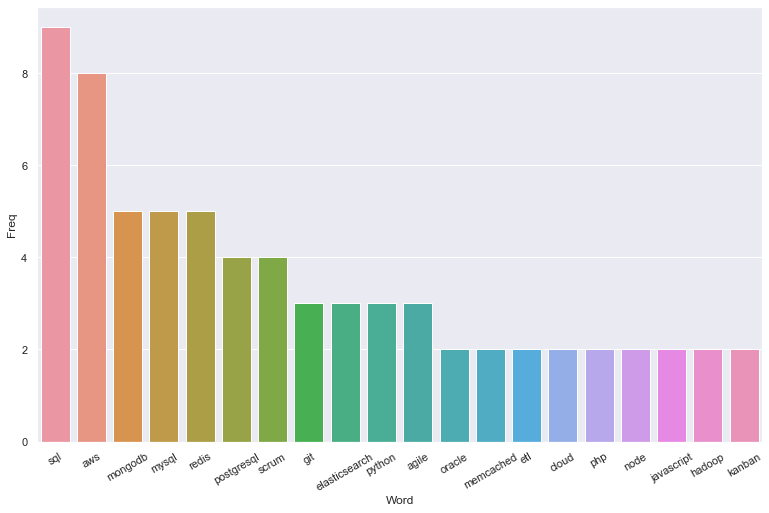

In [156]:
#Barplot of most freq words
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

In [157]:
user_q.Job_Pattern.values.tolist()

['javascript php python sql bash shell mongodb redis mysql postgresql memcached elasticsearch aws linux mac serverless node react atom phpstorm vim visual studio code agile kanban lean scrum git']

### CountVectorizer

In [158]:
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus[11:21], n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]

[Text(0, 0, 'sql'),
 Text(1, 0, 'javascript'),
 Text(2, 0, 'git'),
 Text(3, 0, 'aws'),
 Text(4, 0, 'linux'),
 Text(5, 0, 'php'),
 Text(6, 0, 'python'),
 Text(7, 0, 'node'),
 Text(8, 0, 'mysql'),
 Text(9, 0, 'css'),
 Text(10, 0, 'postgresql'),
 Text(11, 0, 'react'),
 Text(12, 0, 'agile'),
 Text(13, 0, 'etl'),
 Text(14, 0, 'mongodb'),
 Text(15, 0, 'redis'),
 Text(16, 0, 'scrum'),
 Text(17, 0, 'cloud'),
 Text(18, 0, 'html'),
 Text(19, 0, 'jquery')]

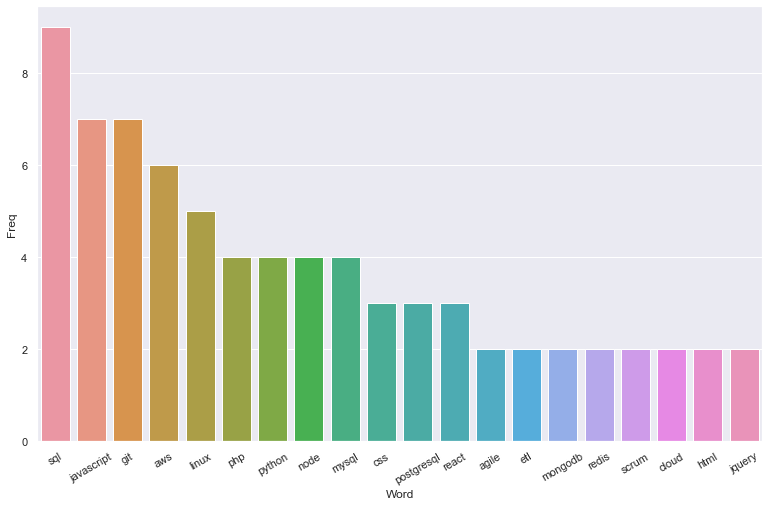

In [159]:
#Barplot of most freq words
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

### Spacy

In [160]:
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus[21:], n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]

[Text(0, 0, 'mysql'),
 Text(1, 0, 'python'),
 Text(2, 0, 'sql'),
 Text(3, 0, 'javascript'),
 Text(4, 0, 'java'),
 Text(5, 0, 'mongodb'),
 Text(6, 0, 'nosql'),
 Text(7, 0, 'linux'),
 Text(8, 0, 'git'),
 Text(9, 0, 'bash'),
 Text(10, 0, 'php'),
 Text(11, 0, 'html'),
 Text(12, 0, 'css'),
 Text(13, 0, 'ruby'),
 Text(14, 0, 'api'),
 Text(15, 0, 'oop'),
 Text(16, 0, 'server'),
 Text(17, 0, 'aws'),
 Text(18, 0, 'angularjs'),
 Text(19, 0, 'oracle')]

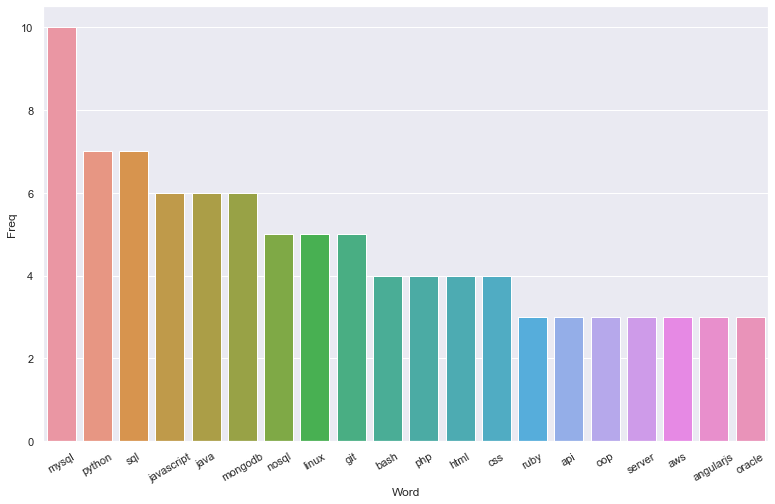

In [161]:
#Barplot of most freq words
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)